# BÀI TOÁN: XÂY DỰNG MÔ HÌNH DỰ ĐOÁN BỆNH ĐỘT QUỴ

- Mục tiêu của bài toán là xây dựng một mô hình học máy có khả năng dự đoán nguy cơ một người có thể bị đột quỵ (stroke), dựa trên các đặc điểm cá nhân và thông tin y tế như tuổi, giới tính, tiền sử bệnh tật, lối sống, v.v.

- Giúp phát hiện sớm người có nguy cơ đột quỵ để can thiệp kịp thời.

- Tối ưu hoá điều trị	Hỗ trợ bác sĩ trong việc phân loại bệnh nhân để ưu tiên theo dõi, xét nghiệm hoặc điều trị.

In [1]:
# Xử lý dữ liệu cơ bản
import pandas as pd
import numpy as np

# Trực quan hóa
import matplotlib.pyplot as plt
import seaborn as sns

# Tiền xử lý dữ liệu
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

# Chia tập và đánh giá mô hình
from sklearn.model_selection import(
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RepeatedStratifiedKFold)

# Các metrics đánh giá mô hình
from sklearn.metrics import(
    confusion_matrix,
    roc_auc_score,
    classification_report,
    accuracy_score,
    precision_recall_curve)

# Feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif, chi2, f_classif

# Xử lý mất cân bằng nhãn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Đếm tần suất
from collections import Counter

In [2]:
df = pd.read_csv(r'C:\GIT\stroke_prediction_repo\DATA\healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Dataset Information

**Giải thích ý nghĩa các cột trong tập dữ liệu**

| Tên cột              | Ý nghĩa |
|----------------------|--------|
| `id`                 | Mã định danh duy nhất của mỗi cá nhân |
| `gender`             | Giới tính của cá nhân (`Male`, `Female`, hoặc `Other`) |
| `age`                | Tuổi của cá nhân (tính theo năm) |
| `hypertension`       | Tăng huyết áp (0 = Không, 1 = Có) |
| `heart_disease`      | Bệnh tim (0 = Không, 1 = Có) |
| `ever_married`       | Đã từng kết hôn hay chưa (`Yes`, `No`) |
| `work_type`          | Loại hình công việc (`Private`, `Self-employed`, `Govt_job`, `children`, `Never_worked`) |
| `Residence_type`     | Loại nơi cư trú (`Urban` = thành thị, `Rural` = nông thôn) |
| `avg_glucose_level`  | Mức đường huyết trung bình (mg/dL) |
| `bmi`                | Chỉ số khối cơ thể (Body Mass Index) |
| `smoking_status`     | Tình trạng hút thuốc (`formerly smoked`, `never smoked`, `smokes`, `Unknown`) |
| `stroke`             | Đã từng bị đột quỵ hay chưa (0 = Không, 1 = Có) |

In [3]:
#kiểm tra kiểu dữ liệu
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [4]:
df.shape

(5110, 12)

In [5]:
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [6]:
# kiểm tra dữ liệu dữ trùng lặp
df.duplicated().sum()

np.int64(0)

In [7]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [8]:
df.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [10]:
# xem thống kê cơ bản
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,5110.0,36517.829354,21161.721625,67.00,17741.250,36932.000,54682.00,72940.00
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
hypertension,5110.0,0.097456,0.296607,0.00,0.000,0.000,0.00,1.00
heart_disease,5110.0,0.054012,0.226063,0.00,0.000,0.000,0.00,1.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,28.893237,7.854067,10.30,23.500,28.100,33.10,97.60
stroke,5110.0,0.048728,0.215320,0.00,0.000,0.000,0.00,1.00


**Nhận xét thống kê dữ liệu**

**1. `age`**
- Tuổi trung bình: **43.2** tuổi, dao động từ **0.08** đến **82** tuổi.
- Dữ liệu có thể bao gồm trẻ sơ sinh đến người già.

**2. `hypertension` (tăng huyết áp) & `heart_disease` (bệnh tim)**
- Chỉ ~**9.7%** người bị tăng huyết áp.
- Chỉ ~**5.4%** người có bệnh tim.
- Các giá trị này khá thấp, **bất cân bằng nhãn** có thể ảnh hưởng đến mô hình.

**3. `avg_glucose_level`**
- Trung bình: **106.1**, khá gần giới hạn bình thường (dưới 140).
- Có sự **dao động lớn** (std = 45.3, max = 271.74), có thể có **outlier**.

**4. `bmi` (chỉ số cơ thể)**
- Trung bình: **28.89**, nằm trong vùng **thừa cân**.
- Có giá trị **thiếu (missing)** vì count < 5110.
- Giá trị tối đa đến **97.6**, có khả năng có **giá trị ngoại lai**.

**5. `stroke` (đột quỵ - nhãn dự đoán)**
- Tỷ lệ stroke chỉ ~**4.87%**, cho thấy dữ liệu **rất mất cân bằng lớp**.
- Cần xử lý đặc biệt (resampling hoặc class_weight) khi huấn luyện mô hình.

**Kết luận:**
- Dữ liệu **mất cân bằng mạnh** ở nhãn `stroke`.
- Có thể có **outlier** ở các cột `avg_glucose_level` và `bmi`.
- Cần **xử lý missing value** ở cột `bmi`.

In [11]:
# Thống kê mô tả cho các cột dữ liệu định tính
df.describe(include=[object,'category'])

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


In [12]:
# kiểm tra số lượng giá trị duy nhất mỗi cột
df.nunique()

id                   5110
gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   418
smoking_status          4
stroke                  2
dtype: int64

- thông qua việc kiểm tra giá trị duy nhất ta có thể thấy đưọc bất thường ở cột gender: thay vì chỉ có male và female thì xuất hiện thêm 1 giá trị khác.

- độ tuổi bé nhất là 0.08 và lớn nhất là 82 tuổi, mà ở cột age có tới 104 giá trị khác biệt xem xét xử lý

In [13]:
df = df.drop(columns=['id'])

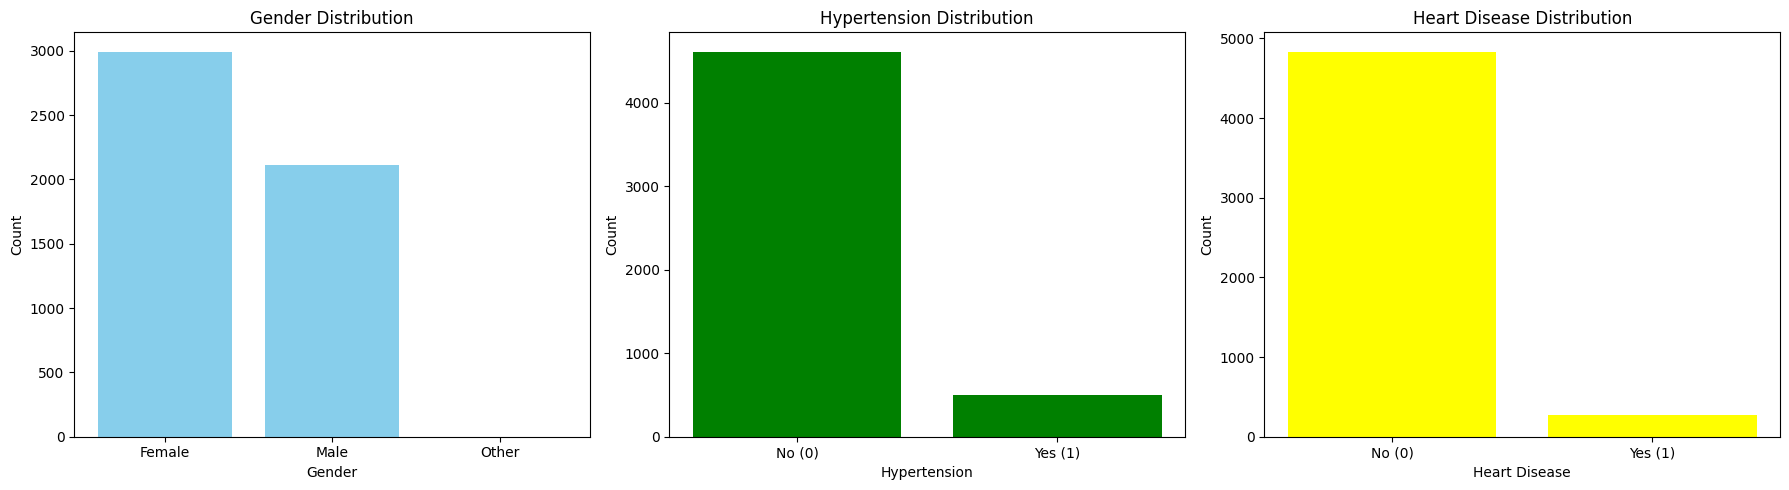

In [15]:
df_gender = df['gender'].value_counts().reset_index(name='count_gender')
df_gender.columns = ['gender', 'count_gender']

df_hypertension = df['hypertension'].value_counts().reset_index(name='count_hypertension')
df_hypertension.columns = ['hypertension', 'count_hypertension']

df_heart_disease = df['heart_disease'].value_counts().reset_index(name='count_heart_disease')
df_heart_disease.columns = ['heart_disease', 'count_heart_disease']

# Tạo figure với 1 hàng và 3 cột
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Biểu đồ giới tính
axes[0].bar(df_gender['gender'], df_gender['count_gender'], color='skyblue')
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Count')
axes[0].set_title('Gender Distribution')

# Biểu đồ hypertension
axes[1].bar(df_hypertension['hypertension'], df_hypertension['count_hypertension'], color='green')
axes[1].set_xlabel('Hypertension')
axes[1].set_ylabel('Count')
axes[1].set_title('Hypertension Distribution')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['No (0)', 'Yes (1)'])

# Biểu đồ heart disease
axes[2].bar(df_heart_disease['heart_disease'], df_heart_disease['count_heart_disease'], color='yellow')
axes[2].set_xlabel('Heart Disease')
axes[2].set_ylabel('Count')
axes[2].set_title('Heart Disease Distribution')
axes[2].set_xticks([0, 1])
axes[2].set_xticklabels(['No (0)', 'Yes (1)'])

# Tự động điều chỉnh khoảng cách giữa các subplot
plt.tight_layout()
plt.show()

- giới tính nam chiếm 58%, giới tính nữ ít hơn giới tính nam, chiếm: 41%
- 'Other': chỉ có 1 giá trị => loại bỏ mà không ảnh hưởng nhiều tới dữ liệu.

- số lượng người không bị tăng huyết áp nhiều hơn gấp 9.2 lần so với những người bị tăng huyết áp.

- số lượng người bị bệnh tim nhiều gấp: 17.5 lần so với những người mắc bệnh tim.

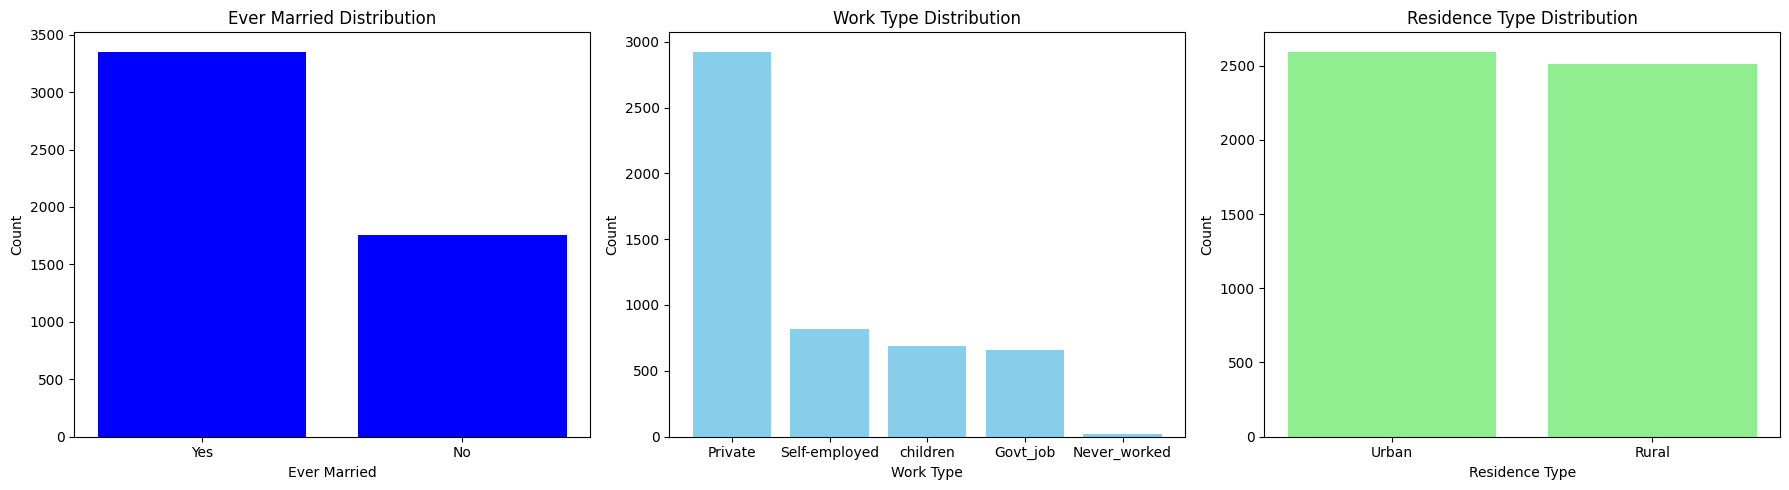

In [19]:
# Chuẩn bị dữ liệu
df_married = df['ever_married'].value_counts().reset_index(name='count_ever_married')
df_married.columns = ['ever_married', 'count_ever_married']

df_work = df['work_type'].value_counts().reset_index(name='count_work_type')
df_work.columns = ['work_type', 'count_work_type']

df_residence = df['Residence_type'].value_counts().reset_index(name='count_residence')
df_residence.columns = ['Residence_type', 'count_residence']

# Tạo figure với 1 hàng và 3 cột
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Biểu đồ ever_married
axes[0].bar(df_married['ever_married'], df_married['count_ever_married'], color='blue')
axes[0].set_xlabel('Ever Married')
axes[0].set_ylabel('Count')
axes[0].set_title('Ever Married Distribution')
# Nếu ever_married chứa chuỗi 'Yes'/'No' thì không cần set_xticks/set_xticklabels

# Biểu đồ work_type
axes[1].bar(df_work['work_type'], df_work['count_work_type'], color='skyblue')
axes[1].set_xlabel('Work Type')
axes[1].set_ylabel('Count')
axes[1].set_title('Work Type Distribution')
axes[1].tick_params(axis='x', rotation=0)

# Biểu đồ Residence_type
axes[2].bar(df_residence['Residence_type'], df_residence['count_residence'], color='lightgreen')
axes[2].set_xlabel('Residence Type')
axes[2].set_ylabel('Count')
axes[2].set_title('Residence Type Distribution')

# Căn chỉnh layout
plt.tight_layout()
plt.show()

- Số lượng người chưa từng kết hôn nhiều hơn gần gấp đôi số lượng người đã kết hôn.

- số lượng người làm công việc 'Private' cao vượt trội(2925) so với phần còn lại, và thấp nhất thuộc nhóm 'Never_worked': 22 người.

- số người sống ở các khu vực 'Urban' và 'Rural' là gần như sau.

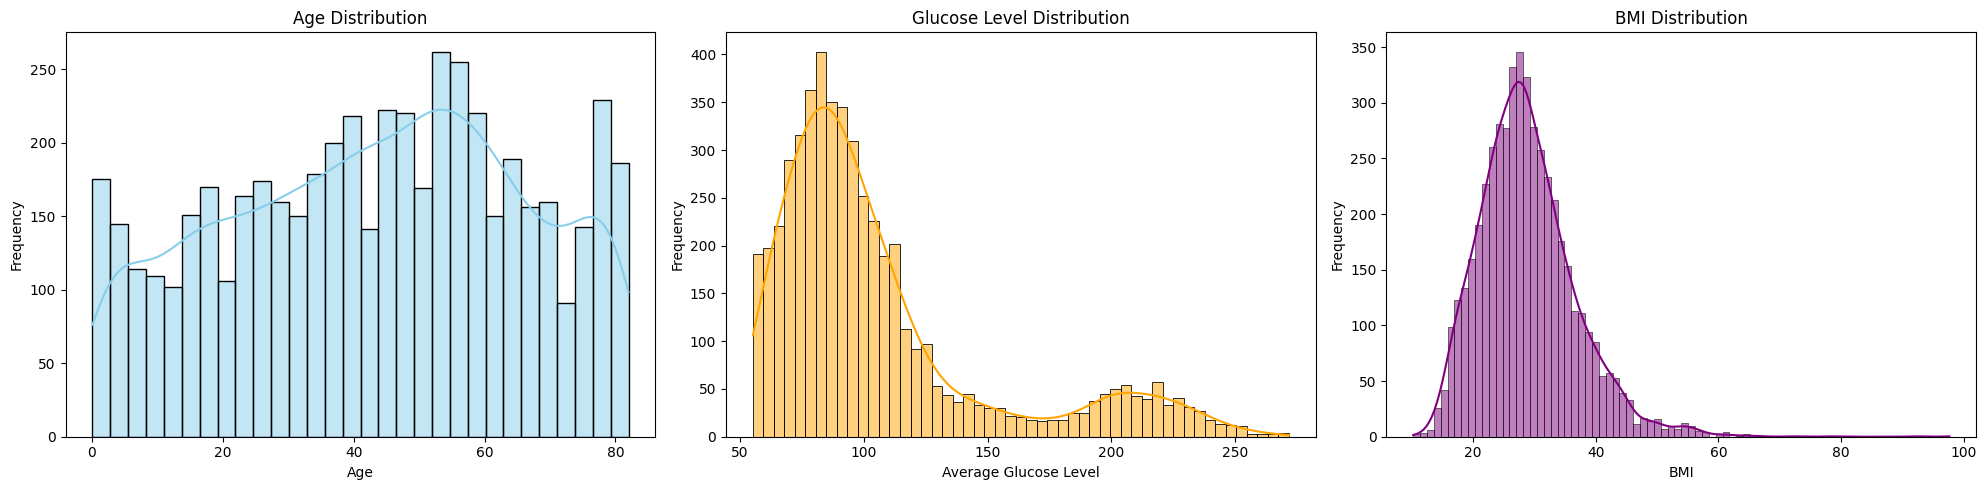

In [24]:
# Tầng suất của từng độ tuổi
age_counts = df['age'].value_counts().sort_index()

# Tạo figure với 1 hàng và 3 cột
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Biểu đồ cột: histplot
sns.histplot(df['age'], bins=30, kde=True, color='skyblue', ax=axes[0])
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Age Distribution')

# Biểu đồ histplot: avg_glucose_level
sns.histplot(df['avg_glucose_level'], kde=True, color='orange', ax=axes[1])
axes[1].set_xlabel('Average Glucose Level')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Glucose Level Distribution')

# Biểu đồ histplot: BMI
sns.histplot(df['bmi'], kde=True, color='purple', ax=axes[2])
axes[2].set_xlabel('BMI')
axes[2].set_ylabel('Frequency')
axes[2].set_title('BMI Distribution')

# Căn chỉnh layout
plt.tight_layout()
plt.show()

- nhìn vào biểu đồ ta có thể thấy độ tuổi trải dài từ 0-82 tuổi.

- Biểu đồ thể hiện phân bố mức đường huyết trung bình (`avg_glucose_level`) của các đối tượng. Dữ liệu có dạng **phân bố lệch phải** (right-skewed), tập trung nhiều nhất trong khoảng **70–120 mg/dL**, sau đó giảm dần về tần suất. Có một số đỉnh nhỏ phụ ở khoảng **200–230 mg/dL**, gợi ý sự tồn tại của các nhóm dân số khác biệt hoặc ngoại lệ y tế.

- Biểu đồ mô tả phân bố chỉ số khối cơ thể (`bmi`) của các đối tượng. Dữ liệu có dạng **phân bố lệch phải nhẹ** với phần lớn giá trị tập trung trong khoảng **20–35**. Đỉnh phân bố nằm quanh **25**, tương ứng với ngưỡng bình thường/cận thừa cân theo chuẩn y tế. Một số giá trị cao bất thường trên **60** xuất hiện với tần suất rất thấp, có thể là **ngoại lệ** hoặc dữ liệu cần xem xét thêm.

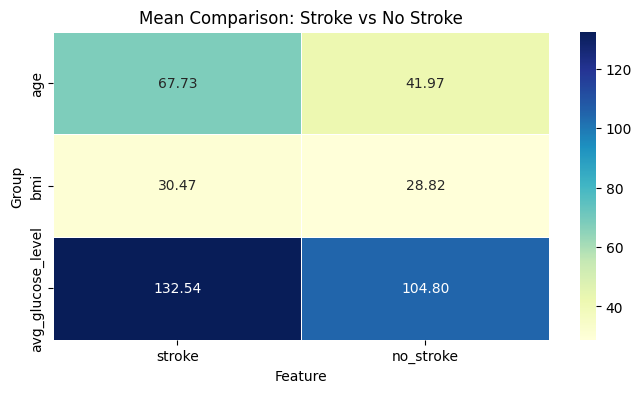

In [27]:
cols = ['age', 'bmi', 'avg_glucose_level']

# Thống kê mô tả theo nhóm
stroke = df[df['stroke'] == 1].describe().T
no_stroke = df[df['stroke'] == 0].describe().T

# Chỉ lấy giá trị trung bình của các cột được chọn
mean_df = pd.DataFrame({
    'stroke': stroke.loc[cols, 'mean'],
    'no_stroke': no_stroke.loc[cols, 'mean']
})

plt.figure(figsize=(8, 4))
sns.heatmap(mean_df, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=0.5)
plt.title("Mean Comparison: Stroke vs No Stroke")
plt.xlabel("Feature")
plt.ylabel("Group")
plt.show()

- các chỉ số trung bình của người bị đột quỵ và không bị đột quỵ

D:\temp\ipykernel_16076\2927345890.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='stroke', data=df, palette=colors, edgecolor='black', ax=axes[1])
D:\temp\ipykernel_16076\2927345890.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['No Stroke', 'Stroke'])


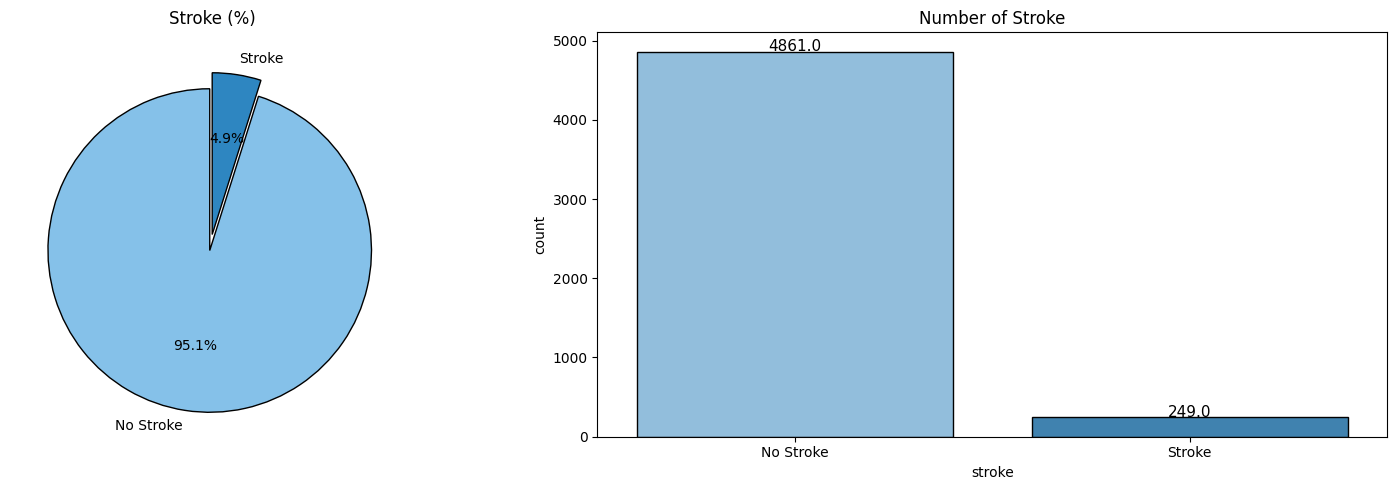

In [28]:
colors = ['#85C1E9', '#2E86C1']
stroke_counts = df['stroke'].value_counts()
circle = stroke_counts / stroke_counts.sum() * 100

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].pie(
    circle,
    labels=['No Stroke', 'Stroke'],
    autopct='%1.1f%%',
    startangle=90,
    explode=(0.1, 0),
    colors=colors,
    wedgeprops={'edgecolor': 'black'}
)
axes[0].set_title('Stroke (%)')

# Count plot
ax = sns.countplot(x='stroke', data=df, palette=colors, edgecolor='black', ax=axes[1])
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_height() + 2, p.get_height(), ha='center', fontsize=11)
ax.set_xticklabels(['No Stroke', 'Stroke'])
ax.set_title('Number of Stroke')

plt.tight_layout()
plt.show()

- Biểu đồ cho thấy sự mất cân đối nghiêm trọng giữa hai nhãn `Stroke` và `No Stroke`. Số lượng mẫu không bị đột quỵ **vượt trội** so với số lượng ca đột quỵ (gần như gấp 20 lần), gây ra hiện tượng **mất cân bằng nhãn (label imbalance)**. Điều này có thể khiến mô hình học máy **thiên lệch** và **giảm độ nhạy (recall)** với các ca đột quỵ – vốn là nhóm quan trọng cần phát hiện.

- **Giải pháp đề suất:** Sử dụng **SMOTE (Synthetic Minority Over-sampling Technique)** để **tăng cường dữ liệu thiểu số**, giúp cân bằng phân bố nhãn và cải thiện hiệu quả mô hình.

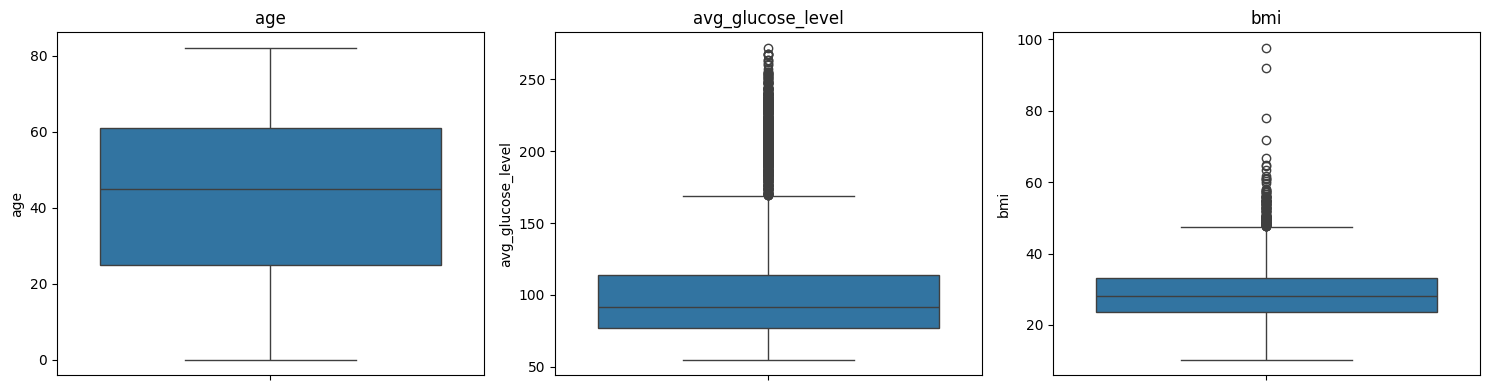

In [ ]:
num_cols = ['age', 'avg_glucose_level', 'bmi']

fig, axes = plt.subplots(nrows=1, ncols=len(num_cols), figsize=(5 * len(num_cols), 4))

# Nếu chỉ có 1 cột, axes sẽ không phải là mảng -> chuyển thành list
if len(num_cols) == 1:
    axes = [axes]

for i, col in enumerate(num_cols):
    sns.boxplot(y=df[col], ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

**Outlier `avg_glucose_level` and `bmi`**

- Biểu đồ hộp cho thấy cả hai biến `avg_glucose_level` và `bmi` đều chứa **nhiều ngoại lệ (outliers)** vượt xa so với phần còn lại của phân bố. Những giá trị này có thể gây ảnh hưởng tiêu cực đến hiệu quả mô hình nếu không được xử lý phù hợp.

- **Định hướng xử lý**: Không sử dụng ngưỡng cắt máy móc, mà dựa vào **biến động sinh lý và kiến thức y khoa**:

- **BMI** hợp lý thường nằm trong khoảng **13–60**, ngoài khoảng này thường do **nhập liệu sai** hoặc các ca cực đoan hiếm gặp.
- **Mức glucose trung bình** hợp lệ được giữ trong khoảng **50–250 mg/dL**, tương ứng với ngưỡng sinh học có thể xảy ra trên thực tế lâm sàng.

- Các outlier nằm ngoài các khoảng giá trị này đã được **loại bỏ thủ công** có cơ sở, giúp làm sạch dữ liệu mà vẫn giữ nguyên tính đại diện của mẫu.aa

# Data Processing

In [37]:
df1 = df.copy()

In [38]:
''' xử lí cột bmi'''

# xử lý thiếu
df1['bmi'].fillna(df1['bmi'].mean(), inplace=True)

D:\temp\ipykernel_16076\1663176536.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['bmi'].fillna(df1['bmi'].mean(), inplace=True)


In [39]:
df1.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [40]:
''' xử lí cột age'''

# ép cột age về kiểu số nguyên
df1['age'] = df1['age'].astype(int)

In [41]:
''' xử lí cột work_type'''

# Chuẩn hóa: chuyển về chữ thường và loại bỏ khoảng trắng đầu/cuối
df1['work_type'] = df1['work_type'].str.strip().str.lower()

In [42]:
df1['work_type'].unique() # kiểm tra lại sau khi xử lý.

array(['private', 'self-employed', 'govt_job', 'children', 'never_worked'],
      dtype=object)

In [43]:
''' xử lí cột gender'''

# xóa giá trị other trong cột 'gender'
df1 = df1[df1['gender'] != 'Other']

In [44]:
print(df1['gender'].unique())

['Male' 'Female']


xử lý cột avg_glucose_level

In [45]:
df1 = df1[df1['avg_glucose_level'] <= 250]

In [46]:
df1['avg_glucose_level'].describe()

count    5084.000000
mean      105.394231
std        44.122678
min        55.120000
25%        77.150000
50%        91.685000
75%       113.585000
max       249.310000
Name: avg_glucose_level, dtype: float64

<Axes: xlabel='avg_glucose_level'>

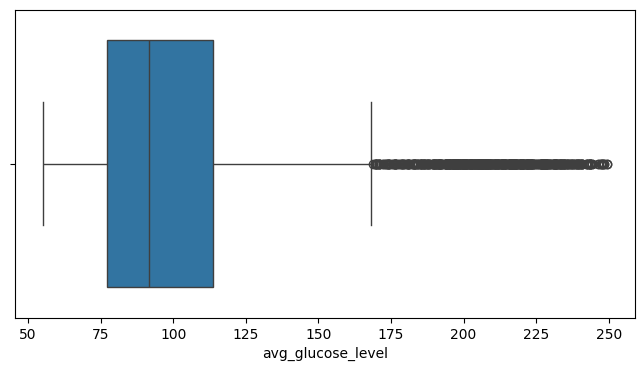

In [47]:
# vẽ boxplot cho cột avg_glucose_level
df_glucose=df1['avg_glucose_level']
plt.figure(figsize=(8, 4))
sns.boxplot(x=df_glucose)

xử lý cột bmi

In [48]:
df1 = df1[(df1['bmi'] > 13) & (df1['bmi'] < 60)]

In [49]:
df1['bmi'].describe()

count    5064.000000
mean       28.803466
std         7.388641
min        13.200000
25%        23.800000
50%        28.400000
75%        32.800000
max        59.700000
Name: bmi, dtype: float64

<Axes: xlabel='bmi'>

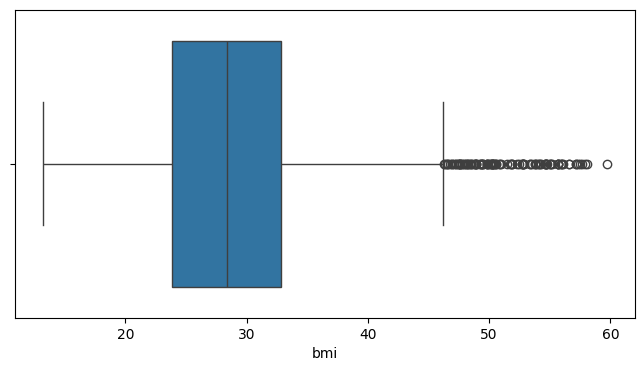

In [50]:
# vẽ biểu đồ boxplot cho cột bmi sau xử lý
df_bmi=df1['bmi']
plt.figure(figsize=(8, 4))
sns.boxplot(x=df_bmi)

Outliers in `avg_glucose_level` and `bmi`:

- Các giá trị ngoại lai (outliers) được hiển thị trong hai biểu đồ boxplot không nhất thiết là "xấu" hay sai lệch. Trên thực tế, chúng phản ánh đúng sự đa dạng sinh học và tình trạng sức khỏe thực tế trong dân số:

- **Chỉ số glucose cao** có thể đến từ các bệnh nhân **tiểu đường type 2 hoặc rối loạn đường huyết**, hoàn toàn hợp lý trong bối cảnh dữ liệu y tế.
- **BMI cao vượt chuẩn** thường xuất hiện ở các trường hợp **béo phì cấp độ cao**, và vẫn nằm trong giới hạn sinh lý có thể xảy ra.

- Do đó, thay vì loại bỏ hoàn toàn, các outlier này **có thể được giữ lại**, miễn là được xác nhận là **hợp lệ về mặt nghiệp vụ y khoa**, nhằm đảm bảo mô hình học được từ các trường hợp đặc biệt có ý nghĩa.

In [51]:
df1.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67,0,1,Yes,private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61,0,0,Yes,self-employed,Rural,202.21,28.893237,never smoked,1
2,Male,80,0,1,Yes,private,Rural,105.92,32.500000,never smoked,1
3,Female,49,0,0,Yes,private,Urban,171.23,34.400000,smokes,1
4,Female,79,1,0,Yes,self-employed,Rural,174.12,24.000000,never smoked,1


**Mã hóa các cột phân loại**

In [52]:
features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

label_encoders = {}
l1 = []
l2 = []

print('Label Encoder Transformation:\n')

for col in features:
    le = LabelEncoder()
    df1[col] = le.fit_transform(df1[col].astype(str))
    label_encoders[col] = le

    encoded_vals = list(df1[col].unique())
    decoded_vals = list(le.inverse_transform(encoded_vals))

    l1.append(encoded_vals)
    l2.append(decoded_vals)

    print(f"{col}: {encoded_vals} = {decoded_vals}")

Label Encoder Transformation:

gender: [np.int64(1), np.int64(0)] = ['Male', 'Female']
ever_married: [np.int64(1), np.int64(0)] = ['Yes', 'No']
work_type: [np.int64(3), np.int64(4), np.int64(1), np.int64(0), np.int64(2)] = ['private', 'self-employed', 'govt_job', 'children', 'never_worked']
Residence_type: [np.int64(1), np.int64(0)] = ['Urban', 'Rural']
smoking_status: [np.int64(1), np.int64(2), np.int64(3), np.int64(0)] = ['formerly smoked', 'never smoked', 'smokes', 'Unknown']


In [53]:
# Chia nhóm tuổi theo từng khoảng 5 năm
df1['age_group'] = [int(i / 5) for i in df1['age']]

# Chia nhóm mức đường huyết trung bình theo khoảng 20 đơn vị
df1['avg_glucose_level_group'] = [int(i / 20) for i in df1['avg_glucose_level']]

# Chia nhóm BMI theo từng khoảng 5 đơn vị
df1['bmi_group'] = [int(i / 5) for i in df1['bmi']]

In [ ]:
binning_info = {
    'age_group': 5,
    'avg_glucose_level_group': 20,
    'bmi_group': 5
}

for group_col, interval in binning_info.items():
    print(f"--- Bảng ánh xạ cho cột: {group_col} (khoảng cách {interval}) ---")
    mappings = [f"  Nhóm {g}: Khoảng [{g * interval}, {(g + 1) * interval})" for g in sorted(df1[group_col].unique())]
    print('\n'.join(mappings))
    print("\n")

--- Bảng ánh xạ cho cột: age_group (khoảng cách 5) ---
  Nhóm 0: Khoảng [0, 5)
  Nhóm 1: Khoảng [5, 10)
  Nhóm 2: Khoảng [10, 15)
  Nhóm 3: Khoảng [15, 20)
  Nhóm 4: Khoảng [20, 25)
  Nhóm 5: Khoảng [25, 30)
  Nhóm 6: Khoảng [30, 35)
  Nhóm 7: Khoảng [35, 40)
  Nhóm 8: Khoảng [40, 45)
  Nhóm 9: Khoảng [45, 50)
  Nhóm 10: Khoảng [50, 55)
  Nhóm 11: Khoảng [55, 60)
  Nhóm 12: Khoảng [60, 65)
  Nhóm 13: Khoảng [65, 70)
  Nhóm 14: Khoảng [70, 75)
  Nhóm 15: Khoảng [75, 80)
  Nhóm 16: Khoảng [80, 85)


--- Bảng ánh xạ cho cột: avg_glucose_level_group (khoảng cách 20) ---
  Nhóm 2: Khoảng [40, 60)
  Nhóm 3: Khoảng [60, 80)
  Nhóm 4: Khoảng [80, 100)
  Nhóm 5: Khoảng [100, 120)
  Nhóm 6: Khoảng [120, 140)
  Nhóm 7: Khoảng [140, 160)
  Nhóm 8: Khoảng [160, 180)
  Nhóm 9: Khoảng [180, 200)
  Nhóm 10: Khoảng [200, 220)
  Nhóm 11: Khoảng [220, 240)
  Nhóm 12: Khoảng [240, 260)


--- Bảng ánh xạ cho cột: bmi_group (khoảng cách 5) ---
  Nhóm 2: Khoảng [10, 15)
  Nhóm 3: Khoảng [15, 20)
  Nhóm 4: Kh

D:\temp\ipykernel_16076\3294643380.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='age_group', data=df1, ax=axs[0], palette='Blues')
D:\temp\ipykernel_16076\3294643380.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='avg_glucose_level_group', data=df1, ax=axs[1], palette='Greens')
D:\temp\ipykernel_16076\3294643380.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='bmi_group', data=df1, ax=axs[2], palette='Oranges')


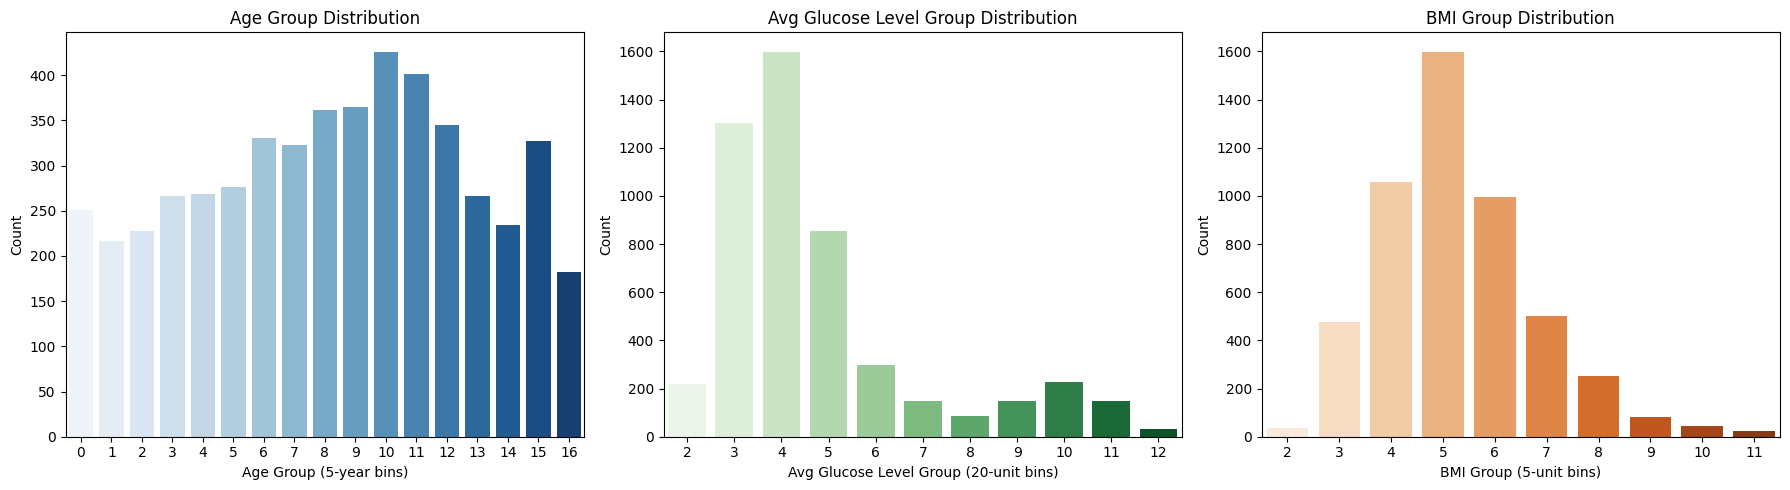

In [55]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Biểu đồ phân phối nhóm tuổi
sns.countplot(x='age_group', data=df1, ax=axs[0], palette='Blues')
axs[0].set_title('Age Group Distribution')
axs[0].set_xlabel('Age Group (5-year bins)')
axs[0].set_ylabel('Count')

# Biểu đồ phân phối nhóm mức đường huyết trung bình
sns.countplot(x='avg_glucose_level_group', data=df1, ax=axs[1], palette='Greens')
axs[1].set_title('Avg Glucose Level Group Distribution')
axs[1].set_xlabel('Avg Glucose Level Group (20-unit bins)')
axs[1].set_ylabel('Count')

# Biểu đồ phân phối nhóm BMI
sns.countplot(x='bmi_group', data=df1, ax=axs[2], palette='Oranges')
axs[2].set_title('BMI Group Distribution')
axs[2].set_xlabel('BMI Group (5-unit bins)')
axs[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

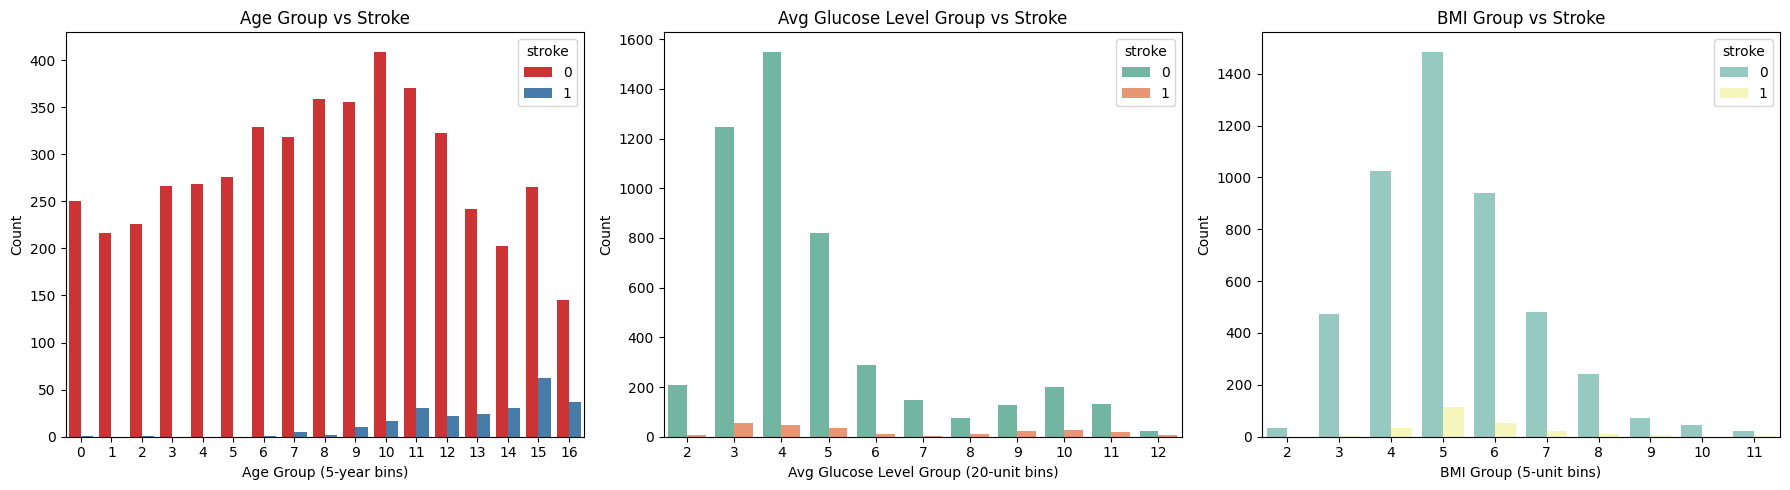

In [56]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Age group vs Stroke
sns.countplot(x='age_group', hue='stroke', data=df1, ax=axs[0], palette='Set1')
axs[0].set_title('Age Group vs Stroke')
axs[0].set_xlabel('Age Group (5-year bins)')
axs[0].set_ylabel('Count')

# Avg glucose level group vs Stroke
sns.countplot(x='avg_glucose_level_group', hue='stroke', data=df1, ax=axs[1], palette='Set2')
axs[1].set_title('Avg Glucose Level Group vs Stroke')
axs[1].set_xlabel('Avg Glucose Level Group (20-unit bins)')
axs[1].set_ylabel('Count')

# BMI group vs Stroke
sns.countplot(x='bmi_group', hue='stroke', data=df1, ax=axs[2], palette='Set3')
axs[2].set_title('BMI Group vs Stroke')
axs[2].set_xlabel('BMI Group (5-unit bins)')
axs[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

- nhìn sơ qua ta có thể quan sát được, nhóm tuổi dễ bị đột quỵ là ở nhóm 9-16(nhóm cao tuổi).

- chỉ số glucose không phản ánh quá rõ ràng về việc dẫn đến đột quỵ.

- chỉ số bmi khá lạ, những người có chỉ số bmi bình thường là từ 24 tới <= 40, thì lại là những người có tỷ lệ mắc bệnh đột quỵ cao nhất. có thể kết hợp từ nhiều yếu tố khác. 1 yếu tố nào đó chưa đủ để cấu thành bệnh đột quỵ

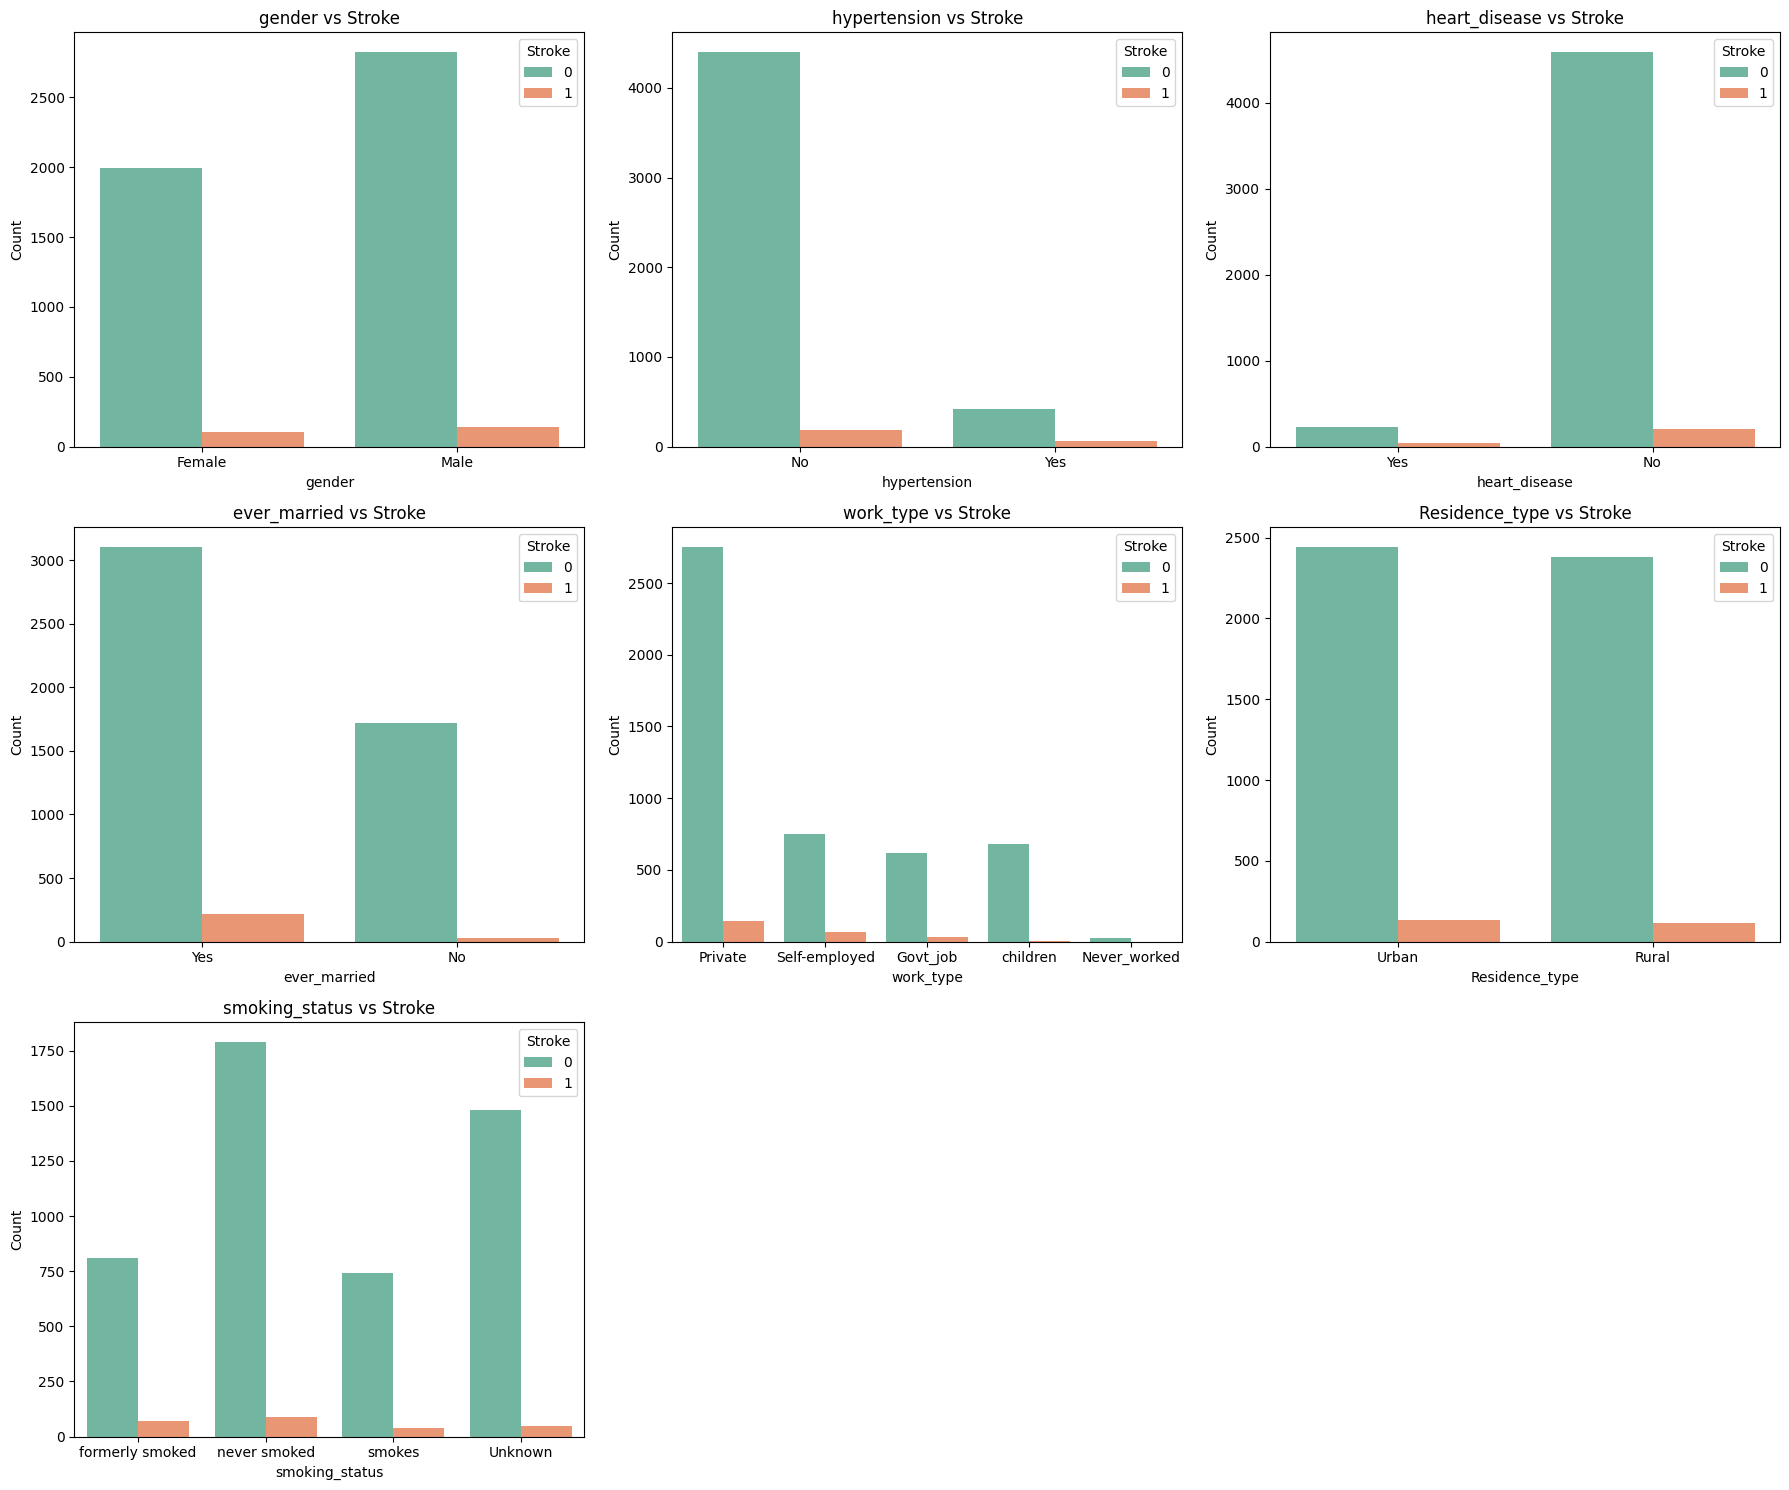

In [57]:
df2 = df1.copy()
# Danh sách các cột phân loại
categorical_features = ['gender', 'hypertension', 'heart_disease',
                        'ever_married', 'work_type',
                        'Residence_type', 'smoking_status']

# Ánh xạ mã hóa về nhãn gốc
mapping_dict = {
    'gender': {0: 'Male', 1: 'Female'},
    'hypertension': {0: 'No', 1: 'Yes'},
    'heart_disease': {0: 'No', 1: 'Yes'},
    'ever_married': {0: 'No', 1: 'Yes'},
    'work_type': {
        3: 'Private',
        4: 'Self-employed',
        1: 'Govt_job',
        0: 'children',
        2: 'Never_worked'
    },
    'Residence_type': {1: 'Urban',0: 'Rural'},
    'smoking_status': {
        1: 'formerly smoked',
        2: 'never smoked',
        3: 'smokes',
        0: 'Unknown'
    }
}

# Tạo thêm các cột nhãn đã giải mã
for col in categorical_features:
    df2[col + '_label'] = df2[col].map(mapping_dict.get(col, {}))

# Thiết lập số hàng/cột cho lưới biểu đồ
num_cols = 3
num_rows = (len(categorical_features) + num_cols - 1) // num_cols

fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols*6, num_rows*5))
axs = axs.flatten()

# Vẽ biểu đồ countplot với nhãn giải mã
for i, col in enumerate(categorical_features):
    sns.countplot(x=col + '_label', hue='stroke', data=df2, ax=axs[i], palette='Set2')
    axs[i].set_title(f'{col} vs Stroke')
    axs[i].legend(title='Stroke', loc='upper right')
    axs[i].set_xlabel(col)  # giữ tên cột gốc để người đọc hiểu
    axs[i].set_ylabel('Count')

# Ẩn các ô trống nếu có
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


- ở bộ dữ liệu này, tỷ lệ nam mắc đột quỵ nhiều hơn nữ.

- hypertension: số lượng người không bị tăng huyết áp có tỷ lệ mắc đột quỵ cao hơn số người bị tăng huyết áp.

- tương tự, số người không bị bệnh tim có tỷ lệ đột quỵ cao hơn những người bệnh tim.

- v.v,

- nhìn vào thì có lẻ đó là điều bất thường nhưng thực sự thì không phải. tại số lượng những người không mắc bệnh cao vượt trội so với những người mắc bệnh, dẫn tới sự phân bố của số người bị đột quỵ ở những người bình thường cũng tăng lên.

**Label Imbalance Treatment**

In [58]:
labels = df1['stroke'].value_counts().reset_index(name='Count_label')
labels.columns = ['stroke', 'Count_label']
print("số lượng nhãn khi chưa xử lí")
labels

số lượng nhãn khi chưa xử lí


,stroke,Count_label
0,0,4820
1,1,244


In [ ]:
over = SMOTE(sampling_strategy = 1)
under = RandomUnderSampler(sampling_strategy = 0.1)
x = df1.loc[:,:'smoking_status']
y = df1.loc[:,'stroke']

steps = [('under', under),('over', over)]
pipeline = Pipeline(steps=steps)
x, y = pipeline.fit_resample(x, y)
Counter(y)

Counter({0: 2440, 1: 2440})

In [60]:
print(f"sau khi sử lí mất cân bằng nhãn:\n{y.value_counts()}")

sau khi sử lí mất cân bằng nhãn:
stroke
0    2440
1    2440
Name: count, dtype: int64


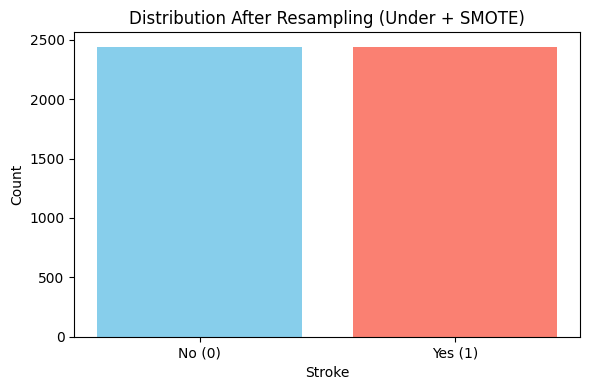

In [61]:
# Đếm số lượng mỗi nhãn sau khi resample
label_counts = Counter(y)

# Chuyển thành DataFrame để dễ vẽ
df_label = pd.DataFrame.from_dict(label_counts, orient='index').reset_index()
df_label.columns = ['stroke', 'count']

# Vẽ biểu đồ cột
plt.figure(figsize=(6, 4))
plt.bar(df_label['stroke'].astype(str), df_label['count'], color=['skyblue', 'salmon'])
plt.xlabel('Stroke')
plt.ylabel('Count')
plt.title('Distribution After Resampling (Under + SMOTE)')
plt.xticks([0, 1], ['No (0)', 'Yes (1)'])
plt.tight_layout()
plt.show()

In [73]:
# chia data thành 2 tập train/test (tỉ lệ train: 80%, test: 20% )
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
print(f"X_train shape: {x_train.shape[0]}, \ny_train shape: {y_train.shape[0]}")
print(f"X_test shape: {x_test.shape[0]}, \ny_test shape: {y_test.shape[0]}")

X_train shape: 3904, 
y_train shape: 3904
X_test shape: 976, 
y_test shape: 976


In [238]:
# Ghép lại x và y thành 1 DataFrame
df_resampled = x.copy()
df_resampled['stroke'] = y

# lưu ra file csv
df_resampled.to_csv('stroke_data.csv', index=False)

In [66]:
x.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,1,76,1,0,1,4,0,69.61,35.3,2
1,0,69,0,1,1,3,1,196.33,25.3,2
2,0,80,1,0,1,4,1,218.00,33.5,0
3,0,34,0,0,1,1,0,70.18,24.9,0
4,0,66,0,0,1,4,0,212.92,21.4,2


In [67]:
y.head(), y.tail()

(0    0
 1    0
 2    0
 3    0
 4    0
 Name: stroke, dtype: int64,
 4875    1
 4876    1
 4877    1
 4878    1
 4879    1
 Name: stroke, dtype: int64)

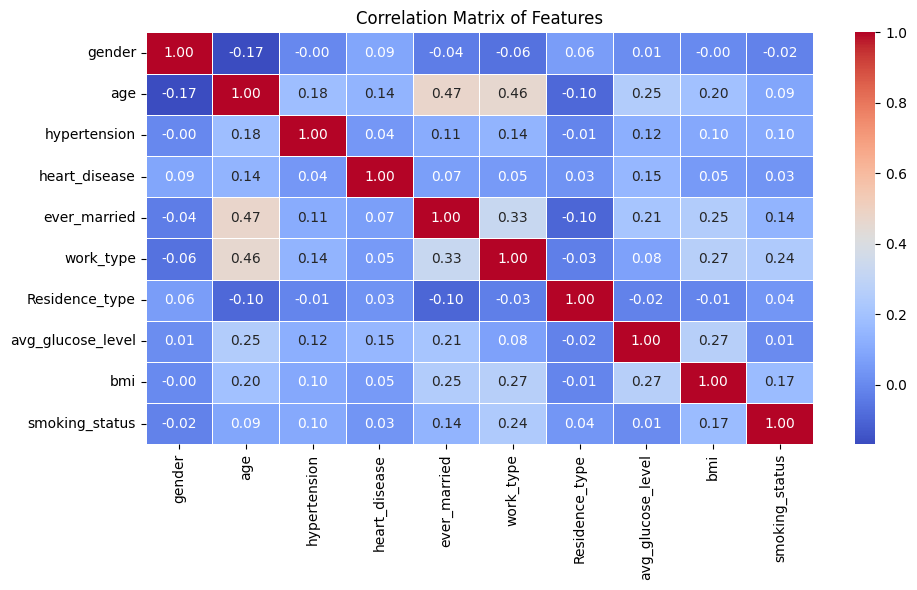

In [68]:
# tính tương quan
corr_matrix = x.corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.tight_layout()
plt.show()

- nhìn chung thì không có các cặp biến nào tương quan quá cao để dẫn tới tình trạng overfiting.

**Đề xuất**:
- Giữ nguyên các biến vì mỗi biến vẫn có giá trị mô tả riêng.
- Kết hợp với các kỹ thuật chọn đặc trưng (feature selection) như **RFE** hoặc **tree-based feature importance** để đánh giá mức đóng góp thực tế.

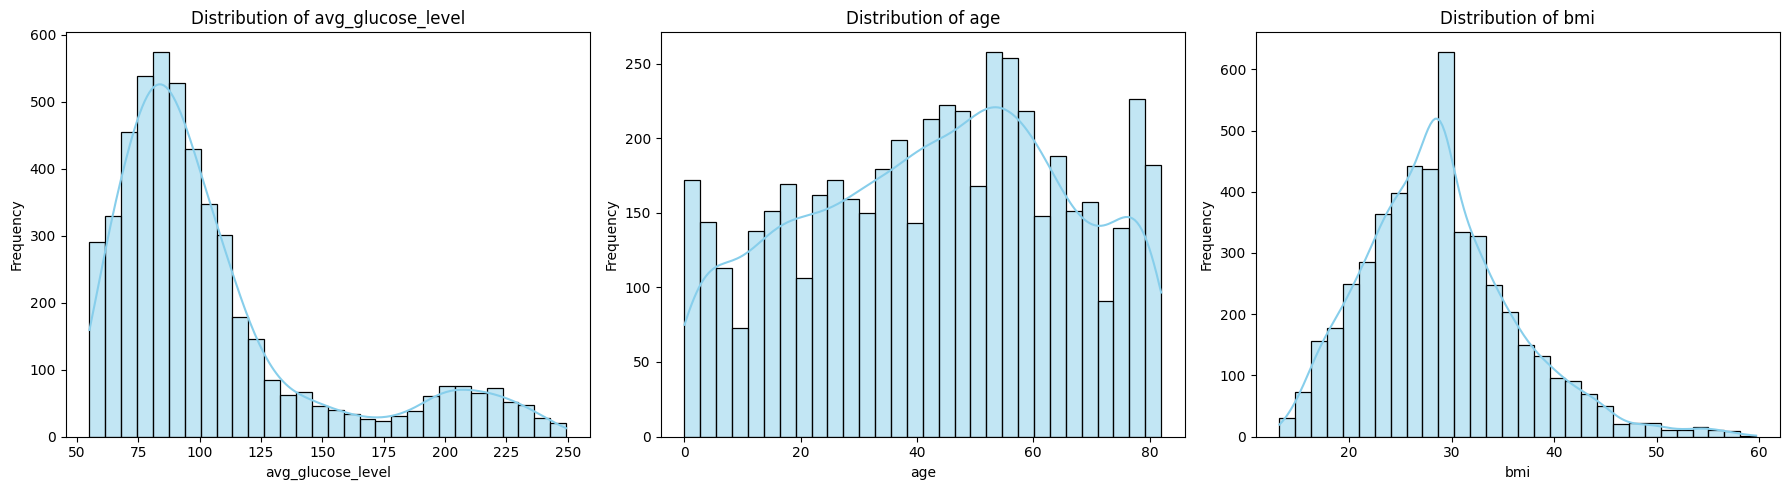

In [242]:
cols = ['avg_glucose_level', 'age', 'bmi']

plt.figure(figsize=(18, 5))

for i, col in enumerate(cols, 1):
    plt.subplot(1, 3, i)
    sns.histplot(df1[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

- nhìn vào biểu đồ có thể thấy được cột **'bmi'** là gần giống phân phối chuẩn nhất => nên chuẩn hóa bằng **StandardScaler**.

- **'avg_glucose_level'** và **'age'** không tuân theo quy luật phân phối chuẩn => nên chuẩn hóa bằng **MinMaxScale**.

In [69]:
# Khởi tạo scaler
ms = MinMaxScaler()
ss = StandardScaler()

# Chuẩn hóa age
x_train['age'] = ms.fit_transform(x_train[['age']])
x_test['age'] = ms.transform(x_test[['age']])

# Chuẩn hóa avg_glucose_level
x_train['avg_glucose_level'] = ms.fit_transform(x_train[['avg_glucose_level']])
x_test['avg_glucose_level'] = ms.transform(x_test[['avg_glucose_level']])

# Chuẩn hóa bmi
x_train['bmi'] = ss.fit_transform(x_train[['bmi']])
x_test['bmi'] = ss.transform(x_test[['bmi']])

In [304]:
import pandas as pd
x_train.to_csv('x_train.csv', index=False)
x_test.to_csv('x_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

c:\python\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


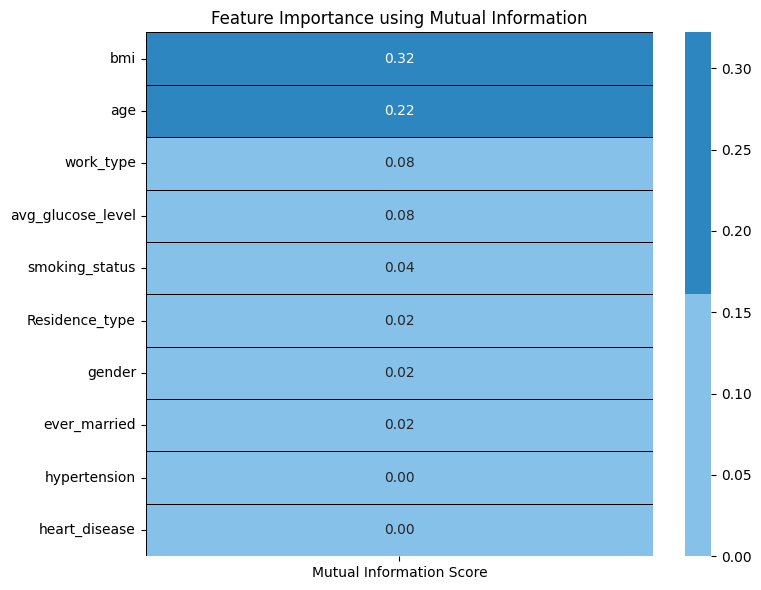

In [74]:
# Đặt đặc trưng và nhãn
features = x_train
target = pd.DataFrame(y_train)

# Tính toán Mutual Information cho tất cả các đặc trưng
mi_func = lambda X, y: mutual_info_classif(X, y, random_state=42)
best_features = SelectKBest(score_func=mi_func, k='all')
fit = best_features.fit(features, target)

# Lưu lại kết quả thành DataFrame
feature_scores = pd.DataFrame(data=fit.scores_,
                               index=features.columns,
                               columns=['Mutual Information Score'])

# Sắp xếp giảm dần theo độ quan trọng
feature_scores_sorted = feature_scores.sort_values(by='Mutual Information Score', ascending=False)

# Vẽ heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(feature_scores_sorted,
            annot=True,
            cmap=colors,
            linewidths=0.4,
            linecolor='black',
            fmt='.2f',
            ax=ax)

plt.title('Feature Importance using Mutual Information')
plt.tight_layout()
plt.show()

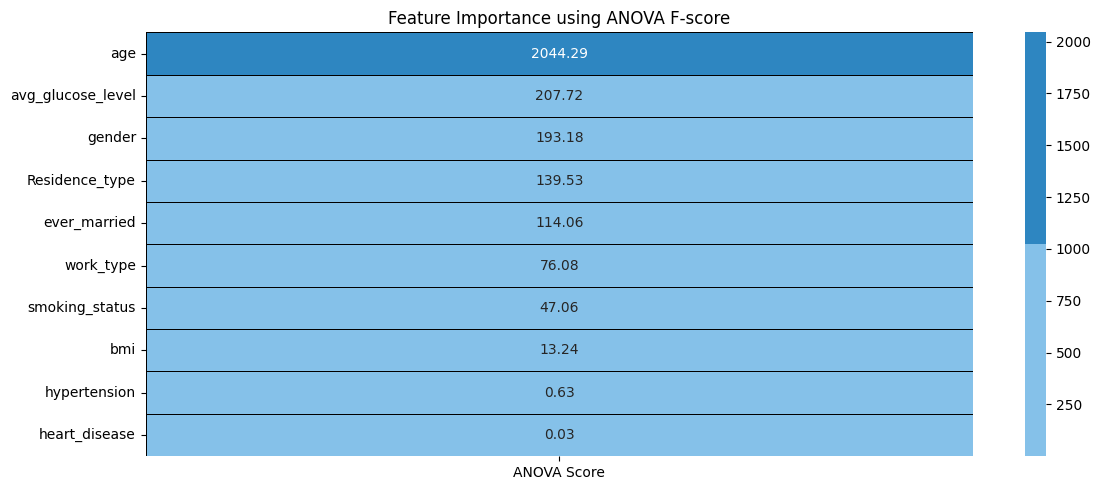

In [71]:
features = x_train
target = y_train

# Tính toán ANOVA F-score cho tất cả đặc trưng
anova_selector = SelectKBest(score_func=f_classif, k='all')
anova_selector.fit(features, target)

# Tạo DataFrame lưu lại điểm số
anova_scores = pd.DataFrame(data=anova_selector.scores_,
                             index=features.columns,
                             columns=['ANOVA Score'])

# Sắp xếp giảm dần theo ANOVA Score
anova_scores_sorted = anova_scores.sort_values(by='ANOVA Score', ascending=False)

# Vẽ biểu đồ heatmap
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5))
sns.heatmap(anova_scores_sorted,
            annot=True,
            cmap=colors,
            linewidths=0.4,
            linecolor='black',
            fmt='.2f',
            ax=ax)

plt.title('Feature Importance using ANOVA F-score')
plt.tight_layout()
plt.show()